## Split board into squares

In [1]:
import cv2
import chess

from scipy.signal import find_peaks, convolve2d
from fastai2.vision.all import *

from utils import *

In [51]:
def save_squares(img, hticks, vticks):
    k = 0
    for i in range(len(hticks)-1):
        for j in range(len(vticks)-1):
            xmin = hticks[i]
            xmax = hticks[i+1]
            ymin = vticks[j]
            ymax = vticks[j+1]
            square = img[xmin:xmax, ymin:ymax]
            cv2.imwrite(f'temp/{k}.png', square)
            k+=1

In [68]:
def make_squares(path):
    img = cv2.imread(path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    horiz = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

    vert = np.array([[1,0,-1],
                     [2,0,-2],
                     [1,0,-1]])

    # blur
    blurred = cv2.blur(gray,(3,3))

    # horizontal and vertical Sobel
    hgrad = convolve2d(blurred, horiz)
    vgrad = convolve2d(blurred, vert)

    # erode
    k = np.ones((3,3), np.uint8)
    hgrad = cv2.erode(hgrad.astype(np.uint8), k)
    vgrad = cv2.erode(vgrad.astype(np.uint8), k)

    # sum absolute values vertically and horizontally
    vlines = np.abs(vgrad).sum(axis=0)
    hlines = np.abs(hgrad).sum(axis=1)
    
    vlines = np.clip((vlines - vlines.max()/2),0,None)
    hlines = np.clip((hlines - hlines.max()/2),0,None)

    vticks = find_peaks(vlines)[0]
    hticks = find_peaks(hlines)[0]
    
    if len(vticks)==9 and len(hticks)==9:
        save_squares(img, hticks, vticks)
    else:
        print(f"Board {path} didn't validate")

In [98]:
boards = Path('boards')
board_path = str(boards.ls()[1])
board_path

'boards/rnbqkbr___p__np_p__p_p______p__pp_____P____PPP___PPNK__PR_BB_QNR.png'

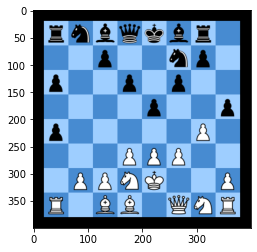

In [99]:
img = cv2.imread(board_path)
show(img)

In [103]:
make_squares(board_path)

## Predict on Squares

In [106]:
learner = load_learner('export.pkl')
temp = Path('temp')

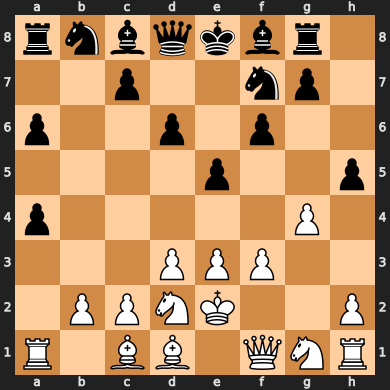

In [107]:
items = []
for i in range(64):
    path = Path(f'temp/{i}.png')
    item = PILImage.create(path)
    items.append(item)

dl = learner.dls.test_dl(items)

_, __, preds = learner.get_preds(dl=dl, with_decoded=True)
classes = learner.dls.vocab
preds = [classes[pred] for pred in preds]
labels = ''.join([label_lib[pred] for pred in preds])
fen = label2fen(labels)
board = chess.Board(fen)
board

In [108]:
empty(temp)